# COGS 108 - Soccer Players' Performances and Their Market Values

## Video Link

https://youtu.be/X3GQEcf7xWo

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [ X ] NO - keep private

# Overview

Soccer is the world's most popular sport, with approximately 250 million players across 200 countries. Like other sports, players who play professionally are paid based on a variety of metrics such as their position, performance, and age. In this exploratory project we hope to investigate how these metrics affect a player's market value and which are most important in determining it. We find that lower age and higher minutes played positively correlate with value. For position specific metrics, we would expect most of them to be positively correlated, but some turned out to be negative. This spurs further investigation on why this may be and the factors that led to this.

# Names

- Eric Manirasith
- Brian Vi
- Alex Liu
- Francesco Parra
- Selim Shaalan

<a id='research_question'></a>
# Research Question

Is there a relationship between a top 5 soccer leagues' player's market value and their in-game performance during the 2019-2020 season? Their in-game performance will be gauged by specifically selected metrics based on their position.

<a id='background'></a>

## Background & Prior Work

In 2020, Borussia Dortmund signed Erling Haaland for just \\$22 million dollars despite Haaland scoring 17 times in the past 16 games. In the previous year Atletico Madrid signed Portuguese forward Joao Felix for \\$140 million dollars, who only scored 15 times almost 30 games. With the astronomical sums being thrown around these days in Soccer, teams are always looking to sign the next big player before they skyrocket in value and become unobtainable. This study aims to examine if there is a significant correlation between a players on the pitch performance, which will be examined through several metrics, and their listed market price.

Prior work:
A 2017 Study conducted by Muller, Simmons and Weinmann titled “Beyond crowd Judgements: Data-driven estimation of market value in association football” attempted to see if a Data driven approach could be used to measure player market value. They used multilevel regression analysis which included a lot of player performance metrics to see if they could produce more accurate estimates of player market value than other traditional crowdsourcing methods such as Transfermarkt, which is the usual source that most people refer to regarding player valuations. Their results showed similar predictions to Transfermarkt which hints at a correlation between performance and value.

References (include links):
- 1) https://www.sciencedirect.com/science/article/pii/S0377221717304332?via%3Dihub

# Hypothesis


We hypothesize that a player's performance will have a positive correlation with their market value, meaning the better they do on the field, the more they will be worth. A player's performance metrics can generally convey how well they are playing currently, attracting attention from teams who may want to recruit him and raising his demand.

# Dataset(s)

- Dataset Name: Soccer players values and their statistics
- Link to the dataset: https://www.kaggle.com/kriegsmaschine/soccer-players-values-and-their-statistics
- Number of observations: 

We had a massive data set with 400 columns, so we decided to only work the variables we deemed important. The variables we decided to keep were player name, position, age, value, minutes, goals_per90, assists per90, shots on target, percentage of completed passes, passes into final third, tackles won, interceptions and clean sheets. We kept the player’s name as a sort of sanity check although it can be argued that it is not quite needed for analysis. Because transfer sums and values are not uniform across positions (expensive goalkeepers usually cost around the 20m while expensive attackers can easily cross 100m), we decided to include the position variable because it wouldn’t be fair to judge a goalkeeper by how many goals they score and other similar comparisons. The rest of the variables are frequently cited metrics that critics, analysts, and fans usually use to evaluate player performance based on position. We also kept some global variables such as age and minutes played which are universal for all players. Finally, we kept the value of the player as our observation vector which we will be evaluating based on the features we chose.

# Setup

In [145]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.api as sm
import patsy

# Data Cleaning

Describe your data cleaning steps here.

In [51]:
data = pd.read_csv('transfermarkt_fbref_201920.csv', delimiter=';', encoding='utf-8')

Of the 400 columns, we select the ones that we feel are relevant for predicting market value from their level of play.

The dataframe has multiple players that have a set of two different positions they play. For the purposes of cleaner data, the players with two positions have their positions sorted in alphabetical order. For example, a player who plays midfielder and forward will always have their position be listed as 'MF,FW' rather than some being 'FW,MF'.

In [147]:
cols = ['player', 'position', 'age', 'value', 'minutes', 'goals_per90', 'assists_per90', 'shots_on_target', \
       'passes_pct', 'tackles_won', 'interceptions', 'clean_sheets', 'save_pct']

data = data[cols]
data = data.replace({'position':{'MF,FW': 'FW,MF','MF,DF': 'DF,MF','FW,DF': 'DF,FW'}})

The data seems to come in a cleaned format, as we can see that all of the columns contain zero null values.

In [148]:
data.isnull().sum()

player             0
position           0
age                0
value              0
minutes            0
goals_per90        0
assists_per90      0
shots_on_target    0
passes_pct         0
tackles_won        0
interceptions      0
clean_sheets       0
save_pct           0
dtype: int64

The two percentage columns, 'passes_pct' and 'save_pct' are not standardized. We need to change 'save_pct' to the same scale as 'passes_pct'. There is some encoding issue with the 'player' column, as many players hail from countries where accents are common in names. However, their names are not a relevant variable for analyzing their market price and only serve as identifiers for each player, so that is fine.

In [176]:
data.head()

,player,position,age,value,minutes,goals_per90,assists_per90,shots_on_target,passes_pct,tackles_won,interceptions,clean_sheets,save_pct
0,Martin Aguirregabiria,DF,23,4000000,2099,0.04,0.04,1,71.2,22,9,0,0.0
1,Oliver Burke,"FW,MF",22,4000000,1429,0.06,0.13,9,67.9,5,6,0,0.0
2,VĂ­ctor Camarasa,MF,25,4000000,1293,0.00,0.07,2,80.7,14,10,0,0.0
3,RubĂ©n Duarte,DF,23,4000000,2663,0.00,0.03,8,71.2,38,19,0,0.0
4,Rodrigo Ely,DF,25,1000000,2121,0.08,0.00,3,79.5,16,12,0,0.0


In [150]:
data['save_pct'] = data['save_pct']*100

We can visualize the descriptive statistics of all numerical variables. For all of the position-focused performance metrics, the statistics seem sensible. The only outlier from these variables is in the 'age' column, where there is an outlier player whose age is 0 years old. We can clean this column by removing players whose ages are under 10, as while it is possible that a high schooler is on track to be scouted and trained for the professional league, it is unlikely that anyone as young as 10 will have played at all.

In [151]:
data[data.columns[2:]].describe()

,age,value,minutes,goals_per90,assists_per90,shots_on_target,passes_pct,tackles_won,interceptions,clean_sheets,save_pct
count,2641.000000,2.641000e+03,2641.000000,2641.000000,2641.000000,2641.00000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000
mean,25.345702,9.581472e+06,1287.281711,0.119216,0.078963,5.41613,77.224801,14.076108,9.506626,0.337751,486.467247
std,4.439636,1.490686e+07,947.012419,0.315225,0.138942,7.99824,11.285120,13.974242,10.013214,1.722261,1777.059021
min,14.000000,5.000000e+01,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,1.000000e+06,430.000000,0.000000,0.000000,0.00000,72.000000,2.000000,1.000000,0.000000,0.000000
50%,25.000000,4.000000e+06,1183.000000,0.000000,0.000000,2.00000,78.200000,10.000000,6.000000,0.000000,0.000000
75%,28.000000,1.200000e+07,2051.000000,0.150000,0.110000,7.00000,84.500000,22.000000,15.000000,0.000000,0.000000
max,41.000000,1.800000e+08,3420.000000,10.000000,1.760000,67.00000,100.000000,89.000000,59.000000,18.000000,10000.000000


In [152]:
data = data[data['age'] > 10]
data.head()

,player,position,age,value,minutes,goals_per90,assists_per90,shots_on_target,passes_pct,tackles_won,interceptions,clean_sheets,save_pct
0,Martin Aguirregabiria,DF,23,4000000,2099,0.04,0.04,1,71.2,22,9,0,0.0
1,Oliver Burke,"FW,MF",22,4000000,1429,0.06,0.13,9,67.9,5,6,0,0.0
2,VĂ­ctor Camarasa,MF,25,4000000,1293,0.00,0.07,2,80.7,14,10,0,0.0
3,RubĂ©n Duarte,DF,23,4000000,2663,0.00,0.03,8,71.2,38,19,0,0.0
4,Rodrigo Ely,DF,25,1000000,2121,0.08,0.00,3,79.5,16,12,0,0.0


For the purpose of our research, we have to first separate the data about the players into the positions that they play. It wouldn't make sense to include some metrics in the analysis for certain positions, such as goals_per90 for goalkeepers given the fact that their task on the field lies elsewhere. We choose to still include standard metrics describing metadata for each player, such as their name, position, and age. Due to the fact that a player can be fielded for multiple positions, these players will be double counted.

In [153]:
std_metrics = ['player', 'position', 'age', 'value', 'minutes']

df_metrics = ['interceptions', 'tackles_won']
fw_metrics = ['goals_per90', 'assists_per90', 'shots_on_target']
gk_metrics = ['clean_sheets', 'save_pct']
mf_metrics = ['assists_per90', 'passes_pct', 'interceptions']

players_df = data[data['position'].str.contains('DF')][std_metrics + df_metrics].reset_index(drop=True)
players_fw = data[data['position'].str.contains('FW')][std_metrics + fw_metrics].reset_index(drop=True)
players_gk = data[data['position'].str.contains('GK')][std_metrics + gk_metrics].reset_index(drop=True)
players_mf = data[data['position'].str.contains('MF')][std_metrics + mf_metrics].reset_index(drop=True)

We choose a pairplot to try to explore the individual trends unique to each position, i.e the trends of metrics
that are fundamental to gauge a player's performance in that specific position. A pairplot is suitable for this
exploration because it allows us to visualize surface level information based on all possible variables included.

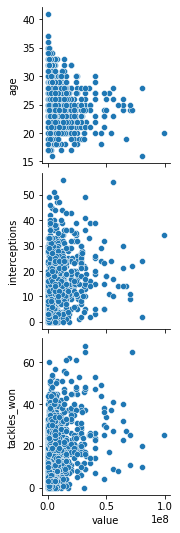

In [154]:
sns.pairplot(data = players_df, y_vars = ['age'] + df_metrics, x_vars = 'value')

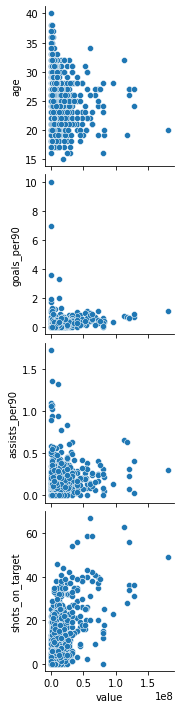

In [155]:
sns.pairplot(data = players_fw, y_vars = ['age'] + fw_metrics, x_vars = 'value')

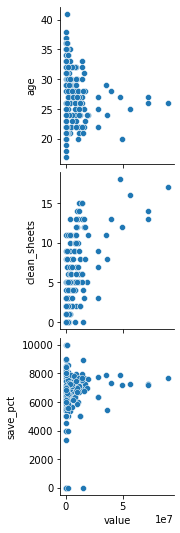

In [156]:
sns.pairplot(data = players_gk, y_vars = ['age'] + gk_metrics, x_vars = 'value')

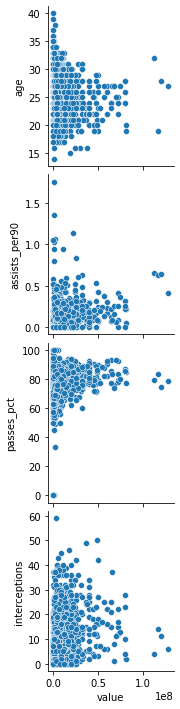

In [157]:
sns.pairplot(data = players_mf, y_vars = ['age'] + mf_metrics, x_vars = 'value')

From the pairplots that we generated, the second column plots each variable against the market values of the players. For the standard variable, age, we can visually infer that there is a weak negative correlation that holds true for fowards, midfielders, and defenders where the higher valued players for these positions lie in the golden range of 25-30 years of age. This may be due to how a player older than this range may be perceived to be past their physical peak compared to a younger one below this range, but the latter may not have as much value because they have less experience on the field. For goalkeepers, the range for higher value players is even smaller, which may be due to how there is only one goalkeeper while other positions have several.

For position specific metrics, there seem to be less variables that correlate with being a higher priced player. Starting with defenders, the distribution of 'interceptions' and 'tackles_won' is continuously clustered on the left, regardless of how high those statistics are, indicating that they do not correlate much with value. There are highly-valued players with both high and low interceptions and tackles won. 

For forwards, the 'goals_per90' and 'assists_per90' metrics are low by nature because there just aren't that many goals happening per game. On the other hand, 'shots_on_target' seems positively correlated with player value because it is basically what the forward is responsible for. We can see that for the highest valued players, they tend to have higher shots on targets than those who are lower.

Moving our focus towards goalkeepers, we can see that there is almost assuredly a positive correlation between 'clean_sheets' and market value. A goalkeeper's clean sheet counts exemplifies their value when playing in that position, showing that they are consistent over the course of a game and how many games that they can hold out with that consistency. Clean sheets are also a team effort, so a high clean sheet could mean that the goalkeeper is on a good team, which inherently adds to their value. 'save_pct' can be deceptive of a goalkeeper's performance because it is too dependent on the level of play (there may be more shots taken at lower levels than at higher levels). However, most players, from the lowest to highest valued ones, uphold a standard of around 70-80% save percentage.

Finally, for midfielders, we see the same trends as with defenders, where the variables are not really correlated with value. It is interesting to note that the 'pass_pct' clusters around 80%, which like the 'save_pct' for goalkeepers, indicates an expected level of play for their respective position.

# Data Analysis & Results

### Analysis on variables that players have less control over

With our analysis, we acknowledge that there is an obvious "well, of course if you perform better as a player, they value you more!" We would also like to draw focus to the factors that players have much less control over, such as 'age' and 'minutes' and cannot be overcome by simply "getting good." While players can have control over 'minutes', they can also get time off the field due to injuries or if the coach decides that he shouldn't get fielded for this specific game.

First, we can look at the distribution of values for all players across all positions. The lines below indicate the cutoff point for a specific percentile, with 'r' (red) being the 50th percentile, 'g' (green) being the 75th percentile, 'b' (dark blue) being the 90th percentile, 'm' (magenta) being the 95th percentile, and 'y' (yellow) being the 99th percentile. This shows how extremely top heavy the soccer league is. Most players are valued at only a fraction of what the top players are valued at.

Cutoffs in value: [4000000.0, 12000000.0, 25000000.0, 40000000.0, 72000000.0]


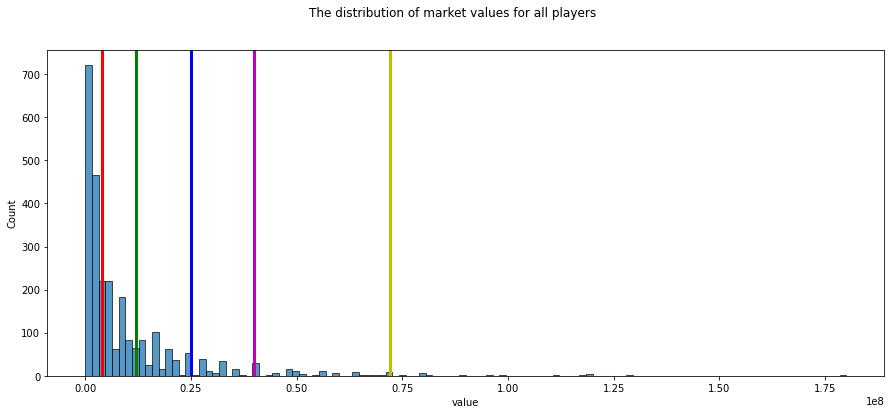

In [178]:
figure(figsize=(15, 6))
sns.histplot(data['value'])
plt.axvline(x = data['value'].quantile(.50), linewidth=3, color='r')
plt.axvline(x = data['value'].quantile(.75), linewidth=3, color='g')
plt.axvline(x = data['value'].quantile(.90), linewidth=3, color='b')
plt.axvline(x = data['value'].quantile(.95), linewidth=3, color='m')
plt.axvline(x = data['value'].quantile(.99), linewidth=3, color='y')
plt.suptitle('The distribution of market values for all players')

print('Cutoffs in value:', [data['value'].quantile(.50), data['value'].quantile(.75), data['value'].quantile(.90), \
      data['value'].quantile(.95), data['value'].quantile(.99)])

To make a subset of our data with this focus, we first take the top 150 earners from every position and aggregate them in one data set. We find that the 'minutes' variable is well distributed, but 'age' suffers from sample size issues, specifically in the range of anyone younger than 19 years and anyone older than 32 years. We remove these from our data set.

In [216]:
top_k = 150

top_df = players_df.sort_values('value', ascending=False)[:top_k].reset_index(drop=True)
top_fw = players_fw.sort_values('value', ascending=False)[:top_k].reset_index(drop=True)
top_gk = players_gk.sort_values('value', ascending=False)[:top_k].reset_index(drop=True)
top_mf = players_mf.sort_values('value', ascending=False)[:top_k].reset_index(drop=True)

top_all = pd.concat([top_df, top_fw, top_gk, top_mf])[['player', 'position', 'age', 'value', 'minutes']] \
    .reset_index(drop=True)

top_all = top_all[(top_all['age'] > 18) & (top_all['age'] < 33)]

<AxesSubplot:xlabel='age', ylabel='Count'>

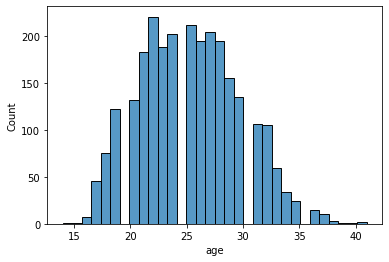

In [218]:
sns.histplot(data['age'])

Text(0.5, 0.98, 'Market value against Age')

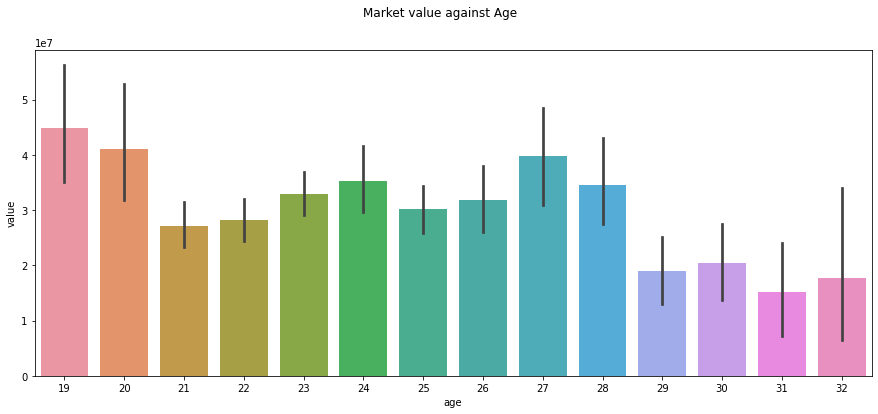

In [215]:
figure(figsize=(15, 6))
sns.barplot(data=top_all, x='age', y='value')

plt.suptitle('Market value against Age')

With this bar plot, we can see that most players are within this golden range of being in your 20s. There seems to be a slight dip with players of ages 21-26, but most players also fall into this age range. Given how top heavy the market valuation for soccer players is, it makes sense that more representation for some category may correlate with lower market values because most players aren't worth that much.

Text(0.5, 0.98, 'Market value against Minutes')

<Figure size 1008x432 with 0 Axes>

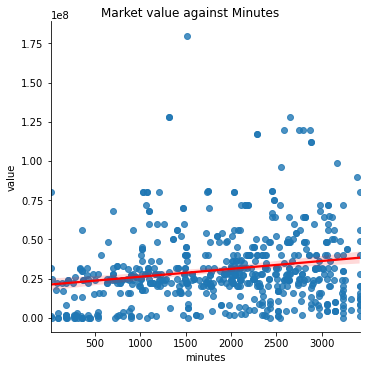

In [204]:
figure(figsize=(14, 6))
sns.lmplot(data=top_all, x='minutes', y='value', line_kws={'color': 'red'})
plt.suptitle('Market value against Minutes')

As shown above, there is a positive correlation between minutes and value, as we had expected. The more play time a player has, the more they can show off their good play or build experience, so they might be worth more due to this.

### Further analysis on variables correlated with value

We perform a basic OLS on the "hard to control" variables that were previously mentioned.

From our OLS results for every position we can see that younger age and more minutes lead to higher valued players.

In [172]:
outcome, predictors = patsy.dmatrices('value~age+minutes', data=data)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     289.2
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          2.69e-114
Time:                        16:49:10   Log-Likelihood:                -47107.
No. Observations:                2641   AIC:                         9.422e+04
Df Residuals:                    2638   BIC:                         9.424e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.948e+07   1.52e+06     12.790      0.000    1.65e+07    2.25e+07
age        -7.273e+05    6.1e+04    -11.916      0.000   -8.47e+05   -6.08e+05
minutes     6627.6153    286.138     23.162      0.000    6066.538    7188.693
==============================================================================
Omnibus:                     2151.588   Durbin-Watson:                   1.200
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65318.317
Skew:                           3.689   Prob(JB):                         0.00
Kurtosis:                      26.220   Cond. No.                     9.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
outcome_df, predictors_df = patsy.dmatrices('value~age+minutes+interceptions+tackles_won', data=players_df)
mod_df = sm.OLS(outcome_df, predictors_df)
res_df = mod_df.fit()
res_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     64.97
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           5.85e-49
Time:                        16:47:00   Log-Likelihood:                -17947.
No. Observations:                1021   AIC:                         3.590e+04
Df Residuals:                    1016   BIC:                         3.593e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.006e+07   1.98e+06     10.133      0.000    1.62e+07    2.39e+07
age           -7.594e+05    7.9e+04     -9.617      0.000   -9.14e+05   -6.04e+05
minutes        6709.4537    707.754      9.480      0.000    5320.628    8098.280
interceptions -1.188e+05   5.64e+04     -2.106      0.035    -2.3e+05   -8106.652
tackles_won   -1.912e+04   4.57e+04     -0.418      0.676   -1.09e+05    7.06e+04
==============================================================================
Omnibus:                      630.736   Durbin-Watson:                   1.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6601.385
Skew:                           2.722   Prob(JB):                         0.00
Kurtosis:                      14.204   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From our OLS results for defenders we can see that younger age, more minutes, having less interceptions, and less tackles leads to higher valued defenders. Less age and more minute leading to a higher valued defender is logical. A possible explaination for less interceptions and tackles leading to higher valued players may be because lower tier divisions/clubs may have lower level of play leading to greater interceptions and tackles per game for lower valued players. However, for high tier divisions/clubs the level of play may be greater leading to less interceptions and tackles per game for high valued players.

In [169]:
outcome_fw, predictors_fw = patsy.dmatrices('value~age+minutes+goals_per90+assists_per90+shots_on_target', data=players_fw)
mod_fw = sm.OLS(outcome_fw, predictors_fw)
res_fw = mod_fw.fit()
res_fw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     106.2
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           6.64e-88
Time:                        16:47:59   Log-Likelihood:                -16031.
No. Observations:                 895   AIC:                         3.207e+04
Df Residuals:                     889   BIC:                         3.210e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.855e+07   2.83e+06      6.545      0.000     1.3e+07    2.41e+07
age             -7.516e+05   1.16e+05     -6.479      0.000   -9.79e+05   -5.24e+05
minutes          -894.7649    947.093     -0.945      0.345   -2753.563     964.033
goals_per90      8.765e+05   1.02e+06      0.859      0.391   -1.13e+06    2.88e+06
assists_per90    1.165e+07   2.89e+06      4.031      0.000    5.98e+06    1.73e+07
shots_on_target   1.04e+06   7.62e+04     13.645      0.000    8.91e+05    1.19e+06
==============================================================================
Omnibus:                      613.599   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9947.879
Skew:                           2.925   Prob(JB):                         0.00
Kurtosis:                      18.249   Cond. No.                     8.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From our OLS results for forward players we can see that younger age, less minutes, more goals, more assists, and more shots on targets lead to higher valued forwards. Less age, more goals. more assists, and more shots on target leading to a higher valued foward is logical. A possible explanation for less minutes leading to higher valued players may be because there are more forwards than any other role. Therefore, forwards are more likely to be rotated or subbed out of the game. Because of this foward player's values are determined more on how well they play instead of how long they play.

In [170]:
outcome_gk, predictors_gk = patsy.dmatrices('value~age+minutes+clean_sheets+save_pct', data=players_gk)
mod_gk = sm.OLS(outcome_gk, predictors_gk)
res_gk = mod_gk.fit()
res_gk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     34.50
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           1.29e-21
Time:                        16:48:05   Log-Likelihood:                -3395.4
No. Observations:                 194   AIC:                             6801.
Df Residuals:                     189   BIC:                             6817.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.477e+07   4.66e+06      3.169      0.002    5.58e+06     2.4e+07
age          -5.048e+05   1.51e+05     -3.345      0.001   -8.03e+05   -2.07e+05
minutes      -1328.8831   1030.433     -1.290      0.199   -3361.511     703.745
clean_sheets  2.044e+06   2.85e+05      7.181      0.000    1.48e+06    2.61e+06
save_pct      -169.4490    460.177     -0.368      0.713   -1077.193     738.295
==============================================================================
Omnibus:                      141.043   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1433.353
Skew:                           2.706   Prob(JB):                         0.00
Kurtosis:                      15.167   Cond. No.                     4.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From our OLS results for goalkeepers we can see that younger age, less minutes, less save percentage, and more clean sheets lead to higher valued goalkeepers. Less age and more clean sheets leading to a higher valued goalkeeper is logical. A possible explanation for less minutes leading to higher valued players may be because low tier clubs/divisions usually only have one or two goalkeepers leading to greater mintues for lower valued players. A possible explanation for less save percentage leading to higher valued players may be because low tier divisons/clubs goal keepers face more score attempts than in higher tier clubs/divisons leading to lower valued goal keepers having greater save percentage. However, we believe clean sheets are a better determining factor than save percentage, because higher valued players in higher divisions/clubs would have more clean sheets than low valued players in lower divisions/clubs.

In [171]:
outcome_mf, predictors_mf = patsy.dmatrices('value~age+minutes+assists_per90+passes_pct+interceptions', data=players_mf)
mod_mf = sm.OLS(outcome_mf, predictors_mf)
res_mf = mod_mf.fit()
res_mf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     86.68
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           9.84e-78
Time:                        16:48:11   Log-Likelihood:                -21128.
No. Observations:                1189   AIC:                         4.227e+04
Df Residuals:                    1183   BIC:                         4.230e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.105e+05   3.37e+06     -0.092      0.927   -6.92e+06     6.3e+06
age           -6.574e+05   8.87e+04     -7.412      0.000   -8.31e+05   -4.83e+05
minutes        8624.7192    675.046     12.776      0.000    7300.299    9949.140
assists_per90  1.954e+07   2.46e+06      7.949      0.000    1.47e+07    2.44e+07
passes_pct      2.14e+05   3.35e+04      6.385      0.000    1.48e+05     2.8e+05
interceptions -2.413e+05   6.19e+04     -3.898      0.000   -3.63e+05    -1.2e+05
==============================================================================
Omnibus:                      802.938   Durbin-Watson:                   1.438
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12220.294
Skew:                           2.940   Prob(JB):                         0.00
Kurtosis:                      17.563   Cond. No.                     1.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From our OLS results for mid fielders we can see that younger age, more minutes, more assists, more passes, and less interceptions lead to higher valued mid fielders. Less age, more minute, more assists, and more passes leading to a higher valued midfielder is logical. A possible explanation for less interceptions leading to higher valued players may be because greater interceptions usually means the player is a defensive mid fielder and defensive mid fielder get valued less than attacking mid fielders.

# Ethics & Privacy

All of the data sets and data snippets that will be used in our project will be publically available data. We took our data off of Kaggle, but an issue with Kaggle sets is that they are often aggregated, scraped data from different sources where we're unsure of whether the data is scrapable. However, with football/soccer specifically, many data sets scrape from Transfermarkt. The site is widely agreed upon to be one of the most reputable and reliable site for statistics on football players, referenced by various news publications and even some agents. Since the data concerns player statistics related to their performance on the field and metadata about such as who they play for, which are all publically available or observable, we do not believe that this will violate their privacy.

# Conclusion & Discussion

We find that overall, a lower age along with more minutes played on the field correlate with higher valuation on the market. For performance metrics specific to certain positions, we find that some metrics did not positively correlate with higher values as we would expect, such as the save percentages for goalkeepers and interceptions for midfielders. One confounding variable we are thinking about is that the difference between high and low level play can skew the metrics in different ways. Further research can be done into this aspect to apply this analysis to a specific set of players.

# Team Contributions

Selim - background research, domain knowledge and expertise, conclusion

Brian - EDA, further analysis coding

Eric - EDA, further analysis coding

Francesco - EDA, ethics, data cleaning

Alex - conclusion, overview, data cleaning